# Introduction

In this notebook, we will attempt to use the powerful tools given to us by NLTK, spacy, and other libraries to create an application that can predict the next word in a tweet that the user wishes to type. The goal of this project isn't just to give one word to the user but a few different options ordered by the probability of each option being the desired next word. In order to achieve a high accuracy score, we will be deploying an unsupervised learning method prior to our supervised learning modeling. We will split the tweets into different categories using LDA. Only after that will we begin modeling but on each cluster individually.

## Data

The data we will be using consists of tweets from the twint API. Information on this API be accessed <a href='https://github.com/twintproject/twint'>here</a>. This API contains not just tweets but loads of information about each tweet which we may be using as well. The Twint API uses web scraping to retrieve this data for us to access through its API. With just a few simple steps, it can be set up without much thought. The specific data we will be accessing from twint are a list of the ten thousand most popular recent tweets. This data will be stored into a pandas data frame to be modified throughout this process. 

## OSEMN Process

# Obtain (O)

In [5]:
pip install twint

  Using cached https://files.pythonhosted.org/packages/69/e1/4daa62fbae8a34558015c227a8274bb2598e0fc6e330bdeb8484ed154ce7/twint-2.1.20.tar.gz
  Using cached https://files.pythonhosted.org/packages/da/01/8f2d49b441573fd2478833bdba91cf0b853b4c750a1fbb9e98de1b94bb22/aiodns-2.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/72/68/76c5d46cc6a48fddb759f585bc8728caa11bfc9b812ce6705fc5f99beab2/elasticsearch-7.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/11/67750d2d6ba48eae602392b55513441058a2a004e5271276df03d3ed6393/aiohttp_socks-0.5.5-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/43/8c/74529fcfbfaa93b8e88ba5d7f883805f87ee167ad878d0638cc012e5acc0/schedule-1.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/67/915668d0e286caa21a1da82a85ffe3d20528ec7212777b43ccd027d94023/geopy-2.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d1/79/af647635d

In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random

import twint
import nest_asyncio # for some reason, needed to excute the api call
nest_asyncio.apply()

# modeling imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
# c = twint.Config()
# c.Search = 'trump'
# c.Limit = 15000
# c.Min_likes = 1000
# c.Lang = 'en'
# c.Store_csv = True
# c.Output = 'trump_tweets.csv'
# c.Hide_output = True
# twint.run.Search(c)

In [8]:
df = pd.read_csv('trump_tweets.csv')

In [9]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1361774593984364549,1361774593984364549,2021-02-16 15:28:58 Eastern Standard Time,2021-02-16,15:28:58,-500,3932768472,emeraldrobinson,Emerald Robinson ✝️,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1361769607317639169,1361769607317639169,2021-02-16 15:09:09 Eastern Standard Time,2021-02-16,15:09:09,-500,4639413136,marklutchman,Mark Lutchman 🇺🇸,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1361768846852554757,1361768846852554757,2021-02-16 15:06:08 Eastern Standard Time,2021-02-16,15:06:08,-500,783792992,ilhanmn,Ilhan Omar,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1361768060017922052,1361768060017922052,2021-02-16 15:03:00 Eastern Standard Time,2021-02-16,15:03:00,-500,25202268,saracarterdc,Sara A. Carter,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1361762378556317700,1361762378556317700,2021-02-16 14:40:26 Eastern Standard Time,2021-02-16,14:40:26,-500,4765364386,chuckcallesto,Chuck Callesto,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [10]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [11]:
df.drop(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id','place','mentions',
       'urls', 'photos', 'replies_count', 'retweets_count','hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'], inplace=True, axis=1)
df.head()

,username,name,tweet,language,likes_count
0,emeraldrobinson,Emerald Robinson ✝️,Why would President Trump meet with Lindsey Gr...,en,1455
1,marklutchman,Mark Lutchman 🇺🇸,Liberals are saying President Trump lost most ...,en,2088
2,ilhanmn,Ilhan Omar,Republicans love Cancel Culture when they can ...,en,4431
3,saracarterdc,Sara A. Carter,Poll: Majority of GOP voters still favor Trump...,en,1428
4,chuckcallesto,Chuck Callesto,Would you SUPPORT a Trump / DeSantis 2024 Pres...,en,3067


In [12]:
# Only keep english tweets
df = df[df['language'] == 'en']

In [13]:
df['language'].value_counts()

en    14505
Name: language, dtype: int64

In [14]:
df.drop(['language'], inplace=True, axis=1)
df.head()

,username,name,tweet,likes_count
0,emeraldrobinson,Emerald Robinson ✝️,Why would President Trump meet with Lindsey Gr...,1455
1,marklutchman,Mark Lutchman 🇺🇸,Liberals are saying President Trump lost most ...,2088
2,ilhanmn,Ilhan Omar,Republicans love Cancel Culture when they can ...,4431
3,saracarterdc,Sara A. Carter,Poll: Majority of GOP voters still favor Trump...,1428
4,chuckcallesto,Chuck Callesto,Would you SUPPORT a Trump / DeSantis 2024 Pres...,3067


# Scrub (S)

## Data inspection

In [15]:
df.isnull().sum()

username       0
name           0
tweet          0
likes_count    0
dtype: int64

## Data scrubbing / cleaning

# Explore (E)

> Because our project is focused on predicting the next desired word, there will be no lemitization necessary during preprocessing. Furthermore, the list of stopwords will have to be focused on misspelled words and the like.

In [16]:
## Analyze Data - EDA

In [17]:
# LDA - tune to see how many topics should implement
cv = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = cv.fit_transform(df['tweet'])
dtm

<14505x10136 sparse matrix of type '<class 'numpy.int64'>'
	with 198002 stored elements in Compressed Sparse Row format>

In [18]:
# Fit 3 subtopics for trump topics
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [19]:
# Grab vocab of words
cv.get_feature_names()[5122]

'kemp'

In [20]:
random_word_id = random.randint(0,7859)
cv.get_feature_names()[random_word_id]

'planning'

In [21]:
# grab topics
single_topic = LDA.components_[0]
single_topic.argsort()

array([4182, 9612, 8704, ..., 2885, 7000, 4457], dtype=int64)

In [22]:
top_fifteen = single_topic.argsort()[-15:]

In [23]:
for index in top_fifteen:
    print(cv.get_feature_names()[index])

justice
just
joe
administration
america
mccarthy
like
amp
election
new
day
biden
donald
president
https


In [24]:
# highest probablility topics
for index,topic in enumerate(LDA.components_):
    print(f"Top 20 words for topic #{index}")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-20:]])
    print('\n')
    print('\n')

Top 20 words for topic #0
['didn', 'media', 'today', 'campaign', 'happy', 'justice', 'just', 'joe', 'administration', 'america', 'mccarthy', 'like', 'amp', 'election', 'new', 'day', 'biden', 'donald', 'president', 'https']




Top 20 words for topic #1
['van', 'amp', 'capitol', 'defense', 'castor', 'know', 'said', 'donald', 'administration', 'president', 'white', 'house', 'people', 'election', 'did', 'lawyer', 'just', 'pence', 'https', 'biden']




Top 20 words for topic #2
['criminal', 'says', 'case', 'legal', 'just', 'breaking', 'witnesses', 'election', 'managers', 'team', 'democrats', 'defense', 'lawyers', 'donald', 'house', 'senate', 'president', 'trial', 'https', 'impeachment']




Top 20 words for topic #3
['incited', 'don', 'just', 'amp', 'voted', 'guilty', 'office', 'president', 'mcconnell', 'senate', 'vote', 'party', 'https', 'senators', 'republicans', 'convict', 'insurrection', 'republican', 'donald', 'gop']




Top 20 words for topic #4
['fight', 'attack', 'time', 'stop', 'j

In [25]:
## tokenize (see second nlp notebook)

In [26]:
# Possibly word cloud

In [27]:
df['tweet']

0        Why would President Trump meet with Lindsey Gr...
1        Liberals are saying President Trump lost most ...
2        Republicans love Cancel Culture when they can ...
3        Poll: Majority of GOP voters still favor Trump...
4        Would you SUPPORT a Trump / DeSantis 2024 Pres...
5        If anyone gets a chance to interview David, I'...
6        Demolition crews are currently ripping out Don...
7        @JDVance1 For five straight years, @twitter an...
8        Trump surprises supporters with drive-by at Pr...
9        POLITICO 2024 PRIMARY POLL:  Donald Trump 53% ...
10       I will never support a leader who voted to acq...
11       @JDVance1 Trump blew off a press conference a ...
12       Trump’s appointed a donor as Postmaster Genera...
13       The only thing better than hearing that Presid...
14       A majority (54%) of Republican voters isn't cl...
15       IMO the big mystery continues to be: Why is Tr...
16       Meghan McCain is not a real conservative, she .

In [28]:
topic_results = LDA.transform(dtm)
topic_results[0].argmax()
df['Topic'] = topic_results.argmax(axis=1)
df[['tweet', 'Topic']].head(15)

,tweet,Topic
0,Why would President Trump meet with Lindsey Gr...,2
1,Liberals are saying President Trump lost most ...,2
2,Republicans love Cancel Culture when they can ...,4
3,Poll: Majority of GOP voters still favor Trump...,3
4,Would you SUPPORT a Trump / DeSantis 2024 Pres...,0
5,"If anyone gets a chance to interview David, I'...",4
6,Demolition crews are currently ripping out Don...,0
7,"@JDVance1 For five straight years, @twitter an...",0
8,Trump surprises supporters with drive-by at Pr...,0
9,POLITICO 2024 PRIMARY POLL: Donald Trump 53% ...,0


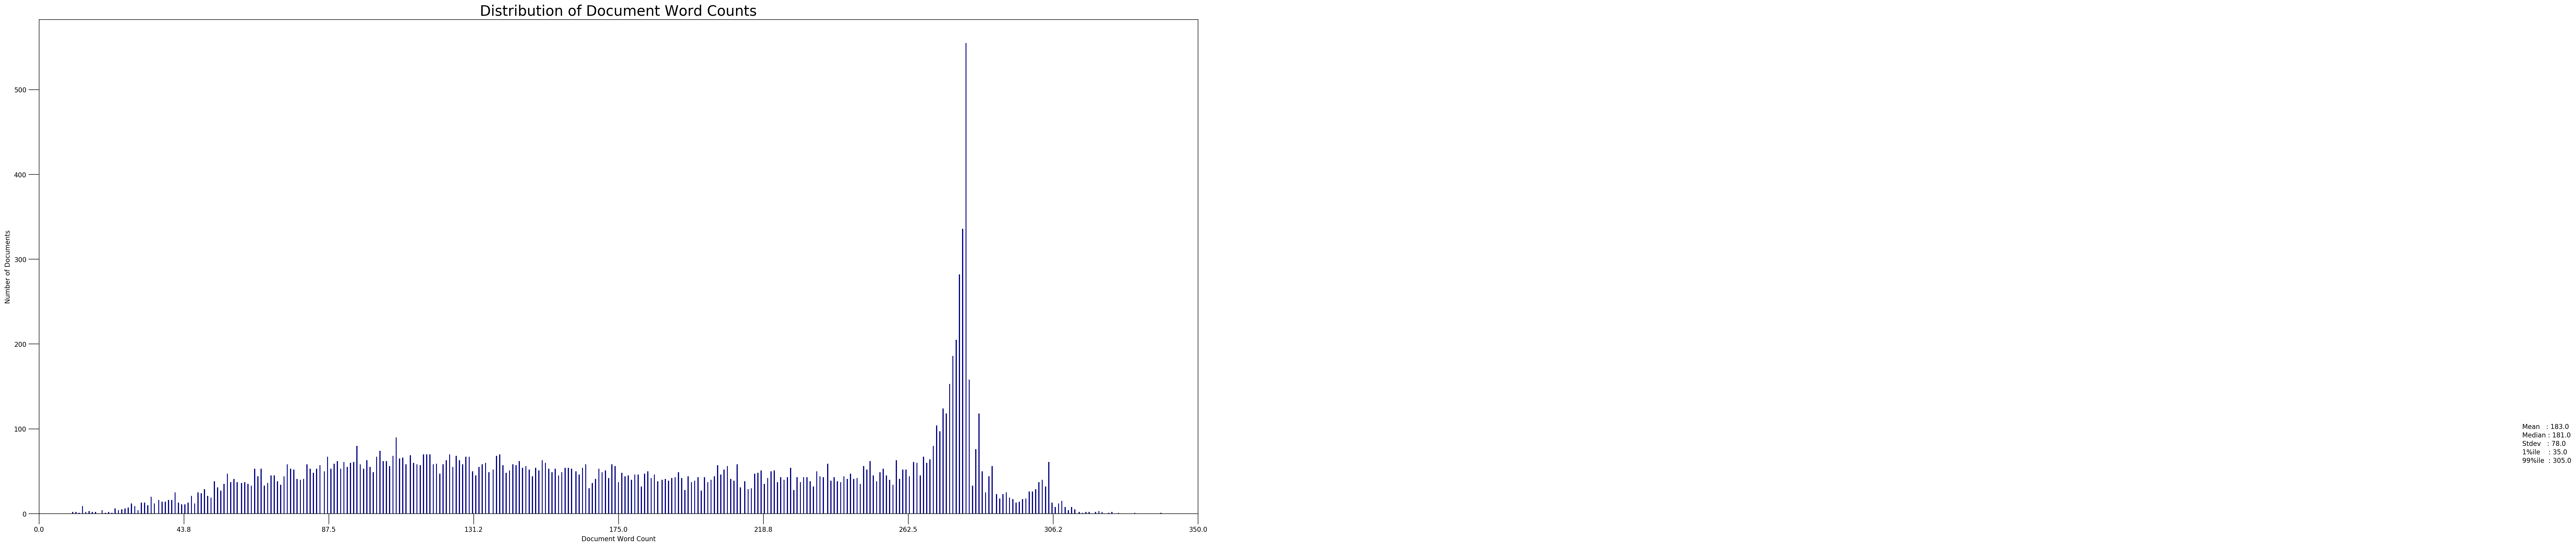

In [29]:
# most used words (freq dist method)
doc_lens = [len(d) for d in df['tweet']]

# Plot
plt.figure(figsize=(32,14), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 300), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,350,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

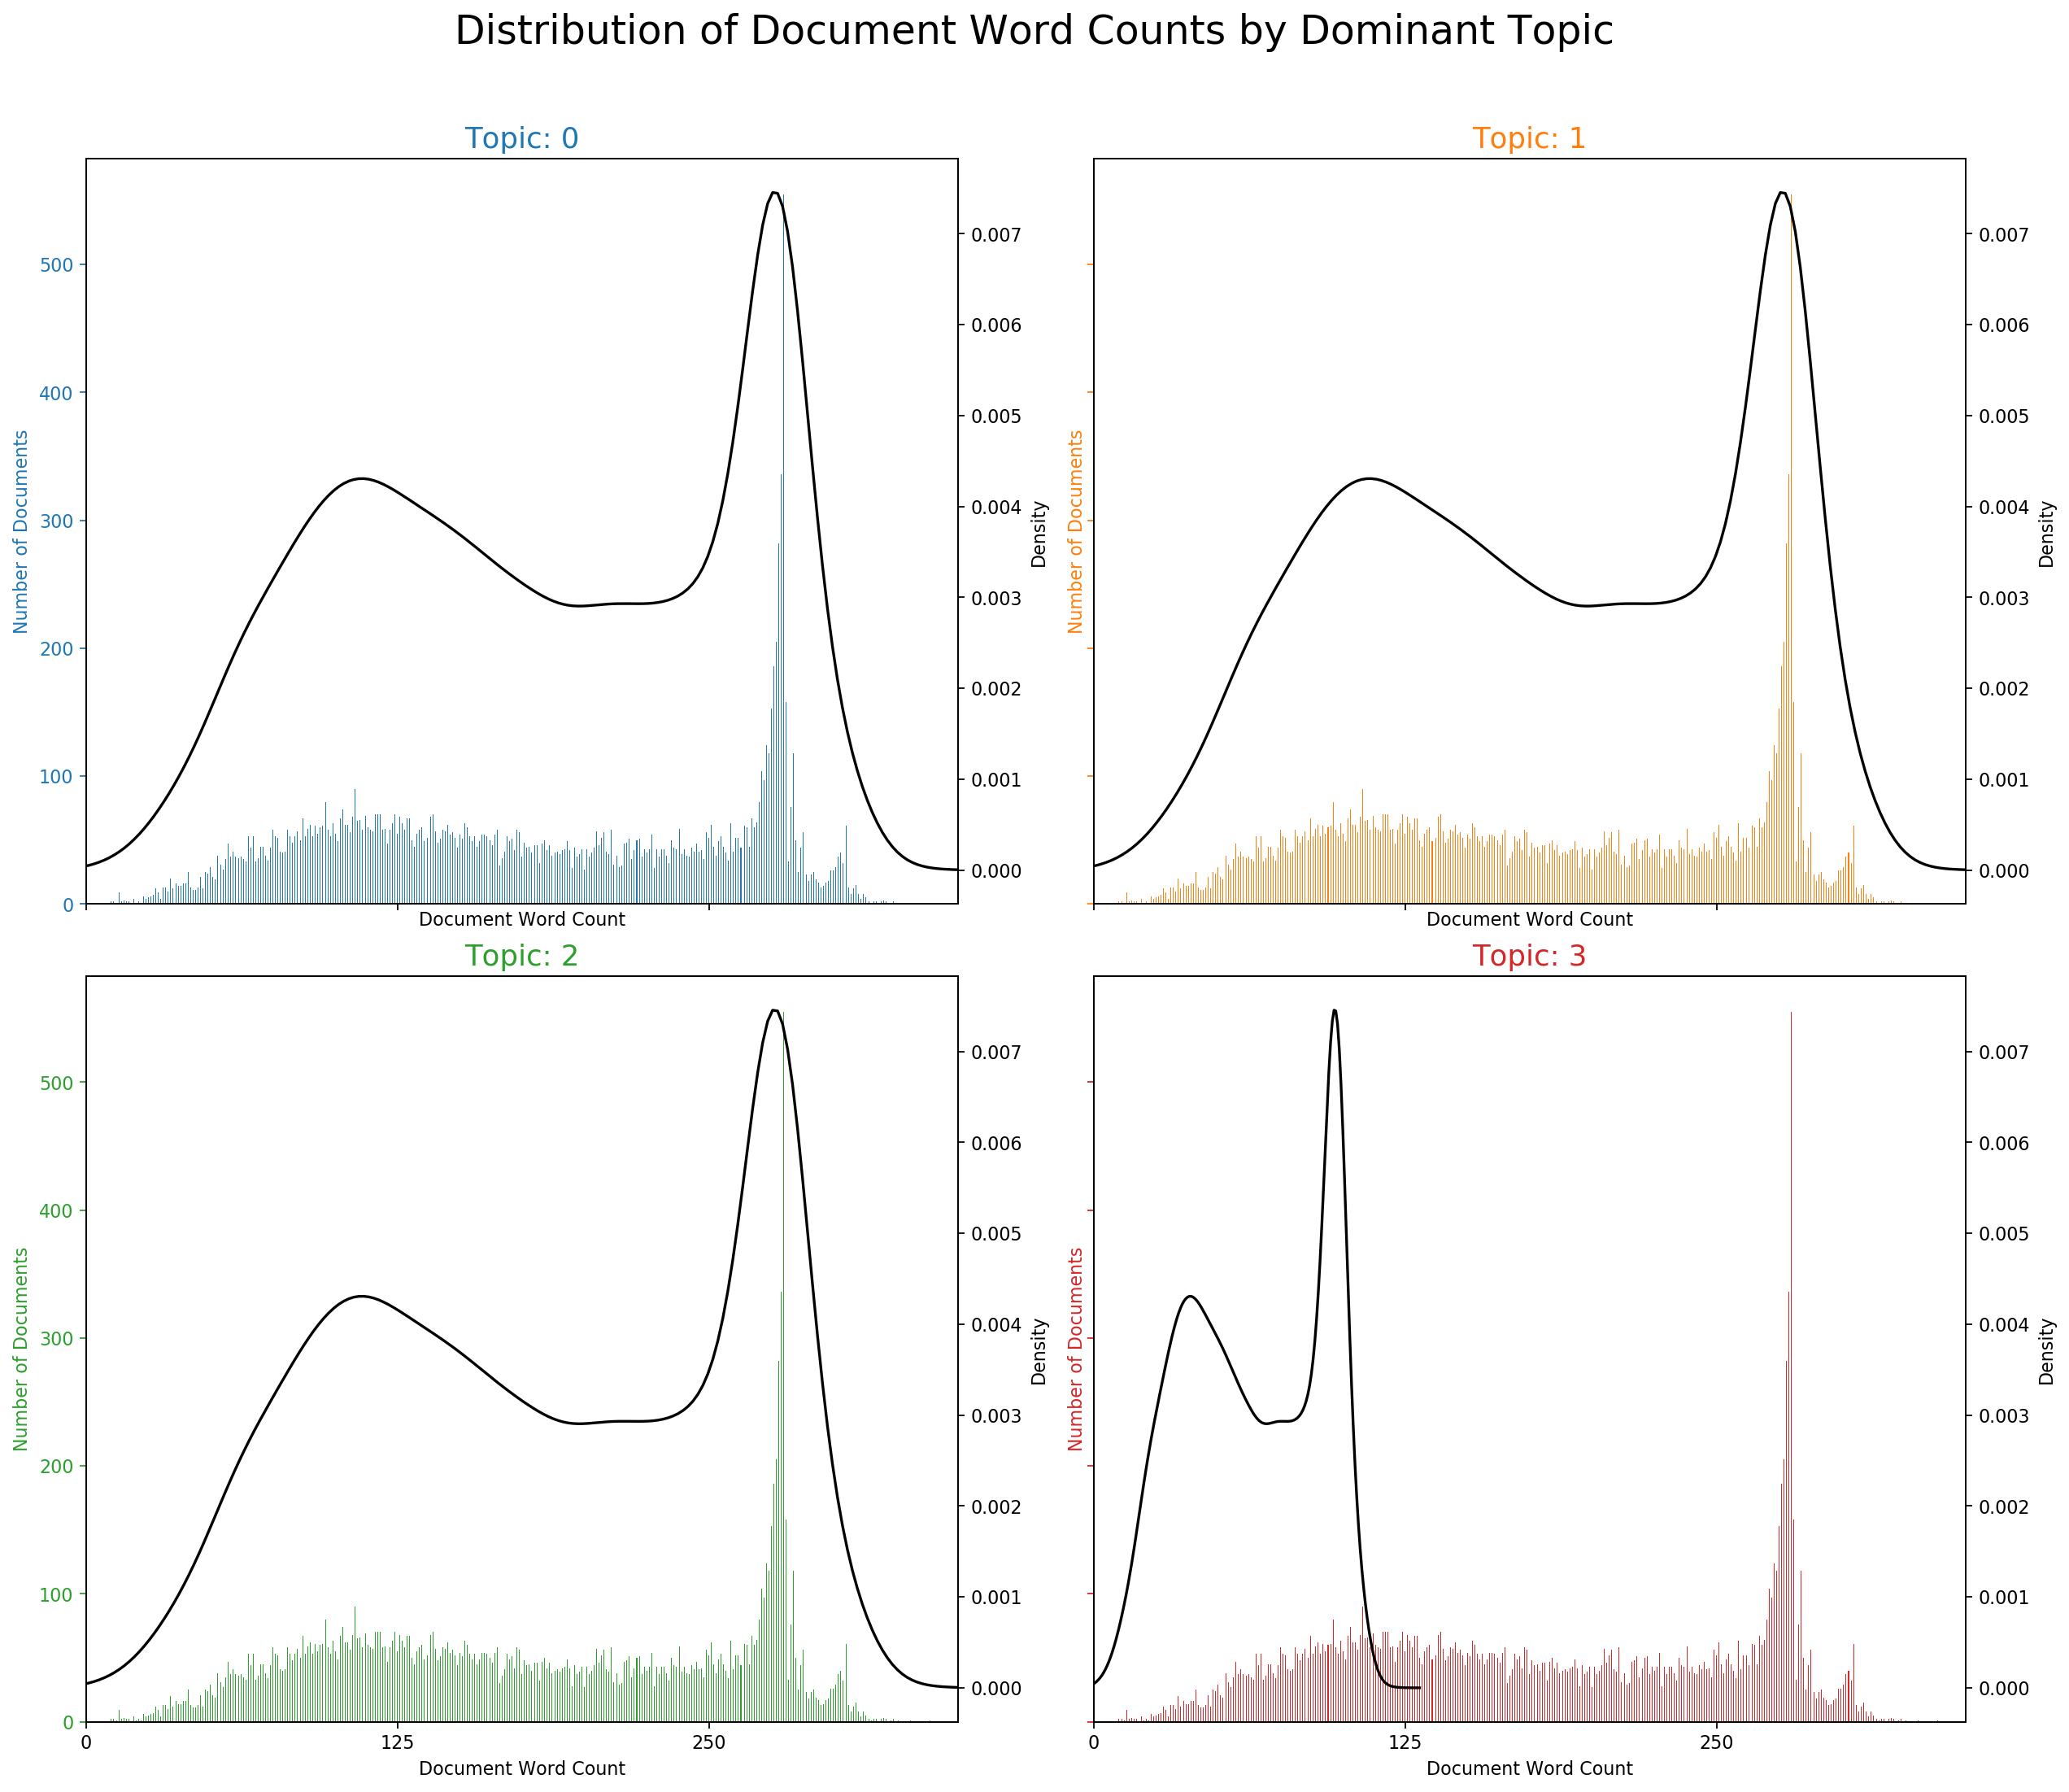

In [30]:
# look up other useful visualizations
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df.loc[df['Topic'] == i, :]
    doc_lens = [len(d) for d in df['tweet']]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 350), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

> This visualization makes it seem as if the topics overlap due to the similarity in distributions

# Model (M)

## Model before preprocessing

In [31]:
# tokenize again (may not need to - depends on model)
# Try at least 3 different models
# Figure out KERAS and nueral networks - start with one


## Preprocess data

In [28]:
# create list of next words based on prev words
word_list = df['tweet'][0].split()

In [29]:
len(word_list)

14

In [30]:
import nltk
nltk.download('punkt')
from nltk.util import ngrams

def extract_ngrams(data, num=2):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [' '.join(grams) for grams in n_grams]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joeyh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
df['2_ngrams'] = df['tweet'].map(extract_ngrams)

In [32]:
df.head()

,username,name,tweet,likes_count,Topic,2_ngrams
0,emeraldrobinson,Emerald Robinson ✝️,Why would President Trump meet with Lindsey Gr...,1455,2,"[Why would, would President, President Trump, ..."
1,marklutchman,Mark Lutchman 🇺🇸,Liberals are saying President Trump lost most ...,2088,2,"[Liberals are, are saying, saying President, P..."
2,ilhanmn,Ilhan Omar,Republicans love Cancel Culture when they can ...,4431,4,"[Republicans love, love Cancel, Cancel Culture..."
3,saracarterdc,Sara A. Carter,Poll: Majority of GOP voters still favor Trump...,1428,3,"[Poll :, : Majority, Majority of, of GOP, GOP ..."
4,chuckcallesto,Chuck Callesto,Would you SUPPORT a Trump / DeSantis 2024 Pres...,3067,0,"[Would you, you SUPPORT, SUPPORT a, a Trump, T..."


In [33]:
def get_top_n_ngram(corpus, n=None, ngrams=2):
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:title={'center':'Top 20 trigrams in review before removing stop words'}, xlabel='ReviewText'>

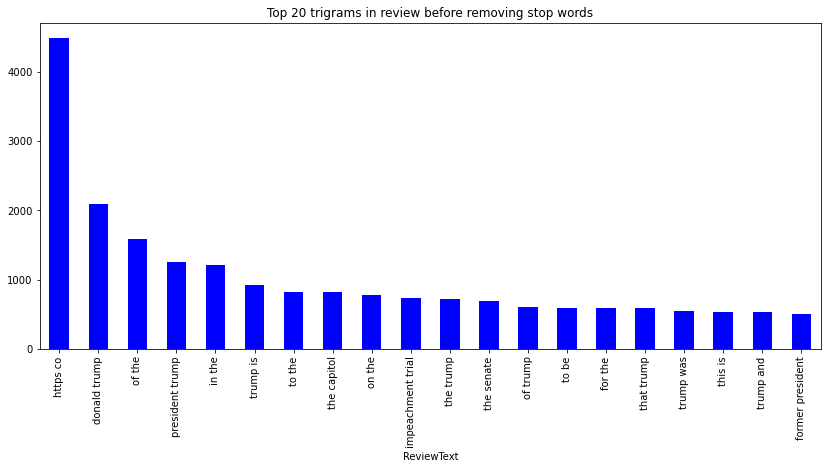

In [34]:
common_phrases = get_top_n_ngram(df['tweet'], 20, 2)
phrases_df = pd.DataFrame(common_phrases, columns = ['ReviewText' , 'count'])
phrases_df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', figsize=(14, 6), color='blue', title='Top 20 trigrams in review before removing stop words')


In [35]:
phrases_df.head()

,ReviewText,count
0,https co,4480
1,donald trump,2087
2,of the,1584
3,president trump,1259
4,in the,1214


## Final Modeling - try out all different models
> Goal is to get High accuracy score

In [56]:
import spacy

In [57]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

In [58]:
def separate_punc(doc_text):
    return [token.text.lower() for token in nlp(doc_text) if token.text not in '-#$&()--.*+,-/:;<=>?@[\\]^_{|}~\t\n ']

In [98]:
df['tweet'][0]

'Why would President Trump meet with Lindsey Graham about the future of the GOP?'

In [138]:
tweet_tokens = df['tweet'].map(separate_punc)

In [141]:
tweet_tokens.head()

0    [why, would, president, trump, meet, with, lin...
1    [liberals, are, saying, president, trump, lost...
2    [republicans, love, cancel, culture, when, the...
3    [poll, majority, of, gop, voters, still, favor...
4    [would, you, support, a, trump, desantis, 2024...
Name: tweet, dtype: object

In [294]:
def get_text_seq(tweet_tokens, train_len=2):
#     train_len = 2+1

    
    text_sequences = []

    for i in range(train_len, len(tokens)):
        for token in tweet_tokens:
            seq = token[i-train_len:i]
            if len(seq) == 2:
                text_sequences.append(seq)
            
    return text_sequences

In [295]:
# def get_text_seq(token, train_len=2):
# #     train_len = 2+1

    
#     text_sequences = []

#     for i in range(train_len, len(tokens)):
        
#         seq = token[i-train_len:i]
#         text_sequences.append(seq)
            
#     return text_sequences

In [296]:
text_sequences = get_text_seq(tweet_tokens)
text_sequences = text_sequences[:40000]

In [297]:
len(text_sequences)

40000

In [298]:
from keras.preprocessing.text import Tokenizer

In [299]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)

In [300]:
sequences = tokenizer.texts_to_sequences(text_sequences)

In [301]:
print(sequences[0])
print(sequences[1])

[80, 66]
[598, 21]


In [302]:
tokenizer.index_word

{1: 'trump',
 2: 'the',
 3: 'is',
 4: 'i',
 5: "'s",
 6: '’s',
 7: 'a',
 8: 'to',
 9: 'of',
 10: 'you',
 11: 'president',
 12: 'this',
 13: '"',
 14: 'if',
 15: 'biden',
 16: 'donald',
 17: 'it',
 18: 'in',
 19: 'that',
 20: 'was',
 21: 'are',
 22: 'just',
 23: 'we',
 24: 'impeachment',
 25: 'on',
 26: 'has',
 27: 'and',
 28: 'breaking',
 29: '“',
 30: 'do',
 31: 'not',
 32: 'senate',
 33: 'defense',
 34: 'for',
 35: 'lawyer',
 36: 'mcconnell',
 37: 'so',
 38: 'have',
 39: 'republicans',
 40: 'who',
 41: 'new',
 42: 'did',
 43: 'lawyers',
 44: 'will',
 45: 'house',
 46: 'says',
 47: 'n’t',
 48: 'now',
 49: 'be',
 50: 'gop',
 51: 'what',
 52: "n't",
 53: 'republican',
 54: 'there',
 55: 'no',
 56: 'senators',
 57: 'how',
 58: 'news',
 59: 'can',
 60: 'democrats',
 61: 'all',
 62: 'one',
 63: 'should',
 64: 'when',
 65: 'they',
 66: 'would',
 67: 'as',
 68: 'people',
 69: 'know',
 70: 'my',
 71: 'from',
 72: 'raskin',
 73: 'only',
 74: 'he',
 75: 'former',
 76: 'with',
 77: 'rep.',
 78: 

In [303]:
tokenizer.word_counts

OrderedDict([('why', 162),
             ('would', 190),
             ('liberals', 16),
             ('are', 521),
             ('republicans', 316),
             ('love', 67),
             ('poll', 49),
             ('majority', 71),
             ('you', 835),
             ('if', 661),
             ('anyone', 78),
             ('demolition', 1),
             ('crews', 2),
             ('@jdvance1', 2),
             ('for', 329),
             ('trump', 5149),
             ('surprises', 2),
             ('politico', 10),
             ('2024', 32),
             ('i', 1280),
             ('will', 291),
             ('’s', 1124),
             ('the', 3078),
             ('only', 173),
             ('a', 1057),
             ('imo', 1),
             ('meghan', 8),
             ('mccain', 14),
             ('obi', 1),
             ('wan', 2),
             ('when', 196),
             ('california', 3),
             ('breaking', 412),
             ('nearly', 10),
             ('all', 225),
     

In [304]:
sequences = np.array(sequences)

In [305]:
sequences

array([[ 80,  66],
       [598,  21],
       [ 39, 159],
       ...,
       [359,  71],
       [ 35,  40],
       [134,   1]])

In [306]:
from keras.utils import to_categorical

In [307]:
vocabulary_size = len(tokenizer.word_counts)

In [308]:
X = sequences[:, :-1]
y = sequences[:, -1]

In [309]:
y

array([ 66,  21, 159, ...,  71,  40,   1])

In [310]:
y = to_categorical(y, num_classes=vocabulary_size+1)

In [311]:
seq_len = X.shape[1]

In [312]:
X.shape

(40000, 1)

In [313]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [314]:
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
    model.add(LSTM(seq_len*2, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(50, activation='relu'))
    
    model.add(Dense(vocabulary_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [315]:
model = create_model(vocabulary_size+1, seq_len)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1, 1)              5812      
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 2)              32        
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 5812)              296412    
Total params: 315,406
Trainable params: 315,406
Non-trainable params: 0
_________________________________________________________________


In [316]:
from pickle import dump, load

In [317]:
model.fit(X, y, batch_size=8, epochs=10, verbose=1)

Epoch 1/10
40000/40000 [==============================] - 63s 2ms/step - loss: 6.7784 - accuracy: 0.0573
Epoch 2/10
40000/40000 [==============================] - 58s 1ms/step - loss: 6.4261 - accuracy: 0.0563
Epoch 3/10
40000/40000 [==============================] - 64s 2ms/step - loss: 6.2946 - accuracy: 0.0605
Epoch 4/10
40000/40000 [==============================] - 58s 1ms/step - loss: 6.1598 - accuracy: 0.0686
Epoch 5/10
40000/40000 [==============================] - 61s 2ms/step - loss: 6.0419 - accuracy: 0.0744
Epoch 6/10
40000/40000 [==============================] - 57s 1ms/step - loss: 5.9525 - accuracy: 0.0810
Epoch 7/10
40000/40000 [==============================] - 58s 1ms/step - loss: 5.8705 - accuracy: 0.0833
Epoch 8/10
40000/40000 [==============================] - 60s 2ms/step - loss: 5.8039 - accuracy: 0.0846
Epoch 9/10
40000/40000 [==============================] - 57s 1ms/step - loss: 5.7564 - accuracy: 0.0856 2s - loss: - ETA: 1s - loss: 5.756 - ETA: 1s - loss: 5.

In [318]:
model.save('initial_tweet_predictor.h5')
# dump(tokenizer, open('tweet_predictor', 'wb'))

# Interpret (I)

## Summarize / Interpret results

# Future work

# Information about myself
* include link to blog about it
* possibly include link to website if I got there
* linkedin and twitter info